<a href="https://colab.research.google.com/github/Madbroo/Deep-Learning/blob/master/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction
In this notebook I tried to implement one of the most popular deep learning model, ResNet, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf) and will train with the SIGNS dataset.

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center><font color='purple'><b>SIGNS dataset</b> </center></caption>



This notebook is part of my assignment of course 4 ([Convolutional Neural Networks](https://www.coursera.org/learn/convolutional-neural-networks?specialization=deep-learning)) in [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning) offered by Deeplearning.ai in Coursera.
And so took significant inspiration from the explanations in that course and its assignments.

In [ ]:
%config Completer.use_jedi=False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [ ]:
!pip install h5py

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, ZeroPadding2D, Activation, BatchNormalization, Conv2D, Flatten, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform, random_uniform, constant, identity
from matplotlib.pyplot import imshow
from tensorflow.python.framework.ops import EagerTensor
import h5py

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/project_folder/cloned_repo_folder

! git pull

### ResNet
In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'></u><font color='purple'>A ResNet block showing a skip-connection <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, we can form a very deep network. 


***Two main types of blocks*** are used in a ResNet, depending mainly on whether the input/output dimensions are the same or different. You are going to implement both of them: the **"identity block"** and the **"convolutional block**."

#### Identity Block
The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'></u><font color='purple'><b>Identity block.</b> Skip connection "skips over" 2 layers. </center></caption>

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center><font color='purple'><b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>

These are the individual steps:

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters.

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The third BatchNorm is normalizing the 'channels' axis.
- Note that there is **no** ReLU activation function in this component. 

Final step (skip connection): 
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- **Hint**: The syntax will look something like `Add()([var1,var2])`
- Then apply the ReLU activation function. This has no hyperparameters. 

In [ ]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    # Retrive filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    
    # Final step (skip connection)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

    

#### Convolutional Block

The ResNet "convolutional block" is the second block type. You can use this type of block ***when the input and output dimensions don't match up***. The difference with the identity block is that <u>there is a CONV2D layer in the shortcut path</u>: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'><font color='purple'><b>Convolutional block</b> </center></caption>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) 
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 
* The `initializer` argument has been set by default to [glorot_uniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform)

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The BatchNorm is normalizing the 'channels' axis. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no hyperparameters. 

In [ ]:
def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform): 
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrive filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    
    # Shortcut Path (skip connection)
    X_shortcut = Conv2D(filters=F3, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)
    
    # Final Step 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    

### Building ResNet-50 (Residual Network with 50 layers)
The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'></u><font color='purple'><b>ResNet-50 model</b></center></caption>
    
The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.


In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((3,3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    
    # Stage 2
    X = convolutional_block(X, 3, [64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
        
    # Stage 3
    X = convolutional_block(X, 3, [128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    # Stage 4
    X = convolutional_block(X, 3, [256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, 3, [512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    
    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2))(X)
    
    # Flatten
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    
    model = Model(inputs=X_input, outputs= X)
    
    return model


In [ ]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def load_dataset():
   
    train_dataset = h5py.File('/content/drive/MyDrive/MyProjects/Deep-Learning/train_ResNet50_model_for SIGN_dataset/datasets/train_signs.h5', "r")
    # Train set features
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    # Train set labels
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  

    
    test_dataset = h5py.File('/content/drive/MyDrive/MyProjects/Deep-Learning/train_ResNet50_model_for SIGN_dataset/datasets/test_signs.h5', "r")
    # Test set features
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    # Test set labels
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  
    
    # List of classes
    classes = np.array(test_dataset["list_classes"][:])  

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [ ]:
model.fit(X_train, Y_train, epochs=15, batch_size=32)

Epoch 1/15
34/34 [==============================] - 10s 85ms/step - loss: 1.7986 - accuracy: 0.4991
Epoch 2/15
34/34 [==============================] - 2s 57ms/step - loss: 0.5692 - accuracy: 0.8139
Epoch 3/15
34/34 [==============================] - 2s 57ms/step - loss: 0.2330 - accuracy: 0.9231
Epoch 4/15
34/34 [==============================] - 2s 57ms/step - loss: 0.3317 - accuracy: 0.9009
Epoch 5/15
34/34 [==============================] - 2s 57ms/step - loss: 0.3696 - accuracy: 0.8843
Epoch 6/15
34/34 [==============================] - 2s 57ms/step - loss: 0.2773 - accuracy: 0.9083
Epoch 7/15
34/34 [==============================] - 2s 58ms/step - loss: 0.1305 - accuracy: 0.9630
Epoch 8/15
34/34 [==============================] - 2s 57ms/step - loss: 0.1330 - accuracy: 0.9611
Epoch 9/15
34/34 [==============================] - 2s 57ms/step - loss: 0.0913 - accuracy: 0.9694
Epoch 10/15
34/34 [==============================] - 2s 57ms/step - loss: 0.0453 - accuracy: 0.9880
Epoch 11

In [ ]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 31ms/step - loss: 0.2251 - accuracy: 0.9333
Loss = 0.22508862614631653
Test Accuracy = 0.9333333373069763


Input image shape: (1, 64, 64, 3)
Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] =  [[0.15444104 0.00077926 0.00193187 0.29249486 0.00077166 0.5495813 ]]
Class: 5


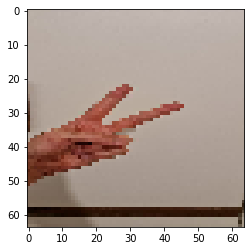

In [ ]:
img_path = '/content/drive/MyDrive/MyProjects/Deep-Learning/train_ResNet50_model_for SIGN_dataset/images/2.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction = model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))


### Bibliography

This notebook presents the ResNet algorithm from He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
